# Track/Segment Person with SiamMask

This notebook uses an open source project [SiamMask](https://github.com/foolwood/SiamMask) to track and to segment a single person on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install SiamMask

In [1]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/foolwood/SiamMask.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q --depth 1 {git_repo_url}
  !sed -i "/torch/d" {project_name}/requirements.txt
  !cd {project_name} && pip install -q -r requirements.txt
  !cd {project_name} && bash make.sh
  !pip install -q youtube-dl
  !pip install pytube
  
import sys
sys.path.append(project_name)
sys.path.append(join(project_name, 'experiments', 'siammask_sharp'))
import time
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

import cv2
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)

from types import SimpleNamespace
from custom import Custom
from tools.test import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 97.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 KB 750.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 33.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 86.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.6/274.6 KB 33.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 102.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━

## Download pretrained weights and initialize SiamMask 

In [2]:
exp_path = join(project_name, 'experiments/siammask_sharp')
pretrained_path1 = join(exp_path, 'SiamMask_DAVIS.pth')
pretrained_path2 = join(exp_path, 'SiamMask_VOT.pth')

# download pretrained weights
if not exists(pretrained_path1):
  !cd {exp_path} && wget http://www.robots.ox.ac.uk/~qwang/SiamMask_DAVIS.pth
if not exists(pretrained_path2):
  !cd {exp_path} && wget http://www.robots.ox.ac.uk/~qwang/SiamMask_VOT.pth
    
# init SiamMask
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cfg = load_config(SimpleNamespace(config=join(exp_path, 'config_davis.json')))
siammask = Custom(anchors=cfg['anchors'])
siammask = load_pretrain(siammask, pretrained_path1)
siammask = siammask.eval().to(device)

--2023-02-17 09:06:10--  http://www.robots.ox.ac.uk/~qwang/SiamMask_DAVIS.pth
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~qwang/SiamMask_DAVIS.pth [following]
--2023-02-17 09:06:10--  https://www.robots.ox.ac.uk/~qwang/SiamMask_DAVIS.pth
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105878246 (101M)
Saving to: ‘SiamMask_DAVIS.pth’

SiamMask_DAVIS.pth  100%[===================>] 100.97M   186MB/s    in 0.5s    

2023-02-17 09:06:11 (186 MB/s) - ‘SiamMask_DAVIS.pth’ saved [105878246/105878246]

--2023-02-17 09:06:11--  http://www.robots.ox.ac.uk/~qwang/SiamMask_VOT.pth
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.u

[2023-02-17 09:06:13,647-rk0-features.py# 66] Current training 0 layers:
	
INFO:global:Current training 0 layers:
	
[2023-02-17 09:06:13,654-rk0-features.py# 66] Current training 1 layers:
	
INFO:global:Current training 1 layers:
	
[2023-02-17 09:06:13,730-rk0-load_helper.py# 31] load pretrained model from SiamMask/experiments/siammask_sharp/SiamMask_DAVIS.pth
INFO:global:load pretrained model from SiamMask/experiments/siammask_sharp/SiamMask_DAVIS.pth
[2023-02-17 09:06:17,878-rk0-load_helper.py# 25] remove prefix 'module.'
INFO:global:remove prefix 'module.'
[2023-02-17 09:06:17,889-rk0-load_helper.py# 18] used keys:356
INFO:global:used keys:356


## Track a person on a test video with SiamMask

We are going to detect and track/segment a person on the following youtube video:

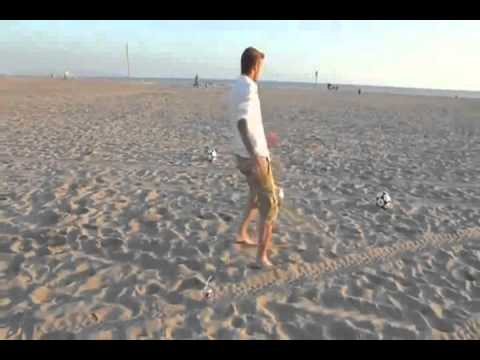

In [3]:
YOUTUBE_ID = 'c_6-8kvLFCs'


YouTubeVideo(YOUTUBE_ID)

Download the above youtube video

In [14]:
from pytube import YouTube

link = 'https://www.youtube.com/watch?v=c_6-8kvLFCs'
youtube = YouTube(link)

print(youtube.title)
video = youtube.streams.get_highest_resolution()
video.download()


David Beckham free kicks on the beach unbelievable


'/content/David Beckham free kicks on the beach unbelievable.mp4'

Detect/track/segment a single person on the first 100 frames:

In [15]:

f = 0
video_capture = cv2.VideoCapture()
if video_capture.open('David Beckham free kicks on the beach unbelievable.mp4'):
  width, height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  
  !rm -f output.mp4 output.avi
  # can't write out mp4, so try to write into an AVI file
  video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
  
  while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
      break

    if f == 0:
      # detect a person on the first frame with Mask R-CNN
      maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
      maskrcnn = maskrcnn.eval()
      output = maskrcnn([torchvision.transforms.functional.to_tensor((frame[...,::-1] / 255).astype(np.float32))])[0]

      target_pos, target_sz = None, None
      for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
        # search for a person with atleast 70% probability
        if score > 0.7 and label == 1:
          box = box.numpy()
          x, y = int(box[0]), int(box[1])
          w, h = int(box[2]) - x, int(box[3]) - y
          target_pos = np.array([x + w / 2, y + h / 2])
          target_sz = np.array([w, h])
          break
      assert target_pos is not None, "no person found on the first frame!"
      print("person found:", target_pos, target_sz)
      
      # init tracker
      state = siamese_init(frame, target_pos, target_sz, siammask, cfg['hp'], device=device)
    else:
      # track
      state = siamese_track(state, frame, mask_enable=True, refine_enable=True, device=device)
      location = state['ploygon'].flatten()
      mask = state['mask'] > state['p'].seg_thr
      
      frame[:, :, 2] = (mask > 0) * 255 + (mask == 0) * frame[:, :, 2]
      cv2.polylines(frame, [np.int0(location).reshape((-1, 1, 2))], True, (0, 255, 0), 3)
      
      video_writer.write(frame)
  
    f += 1
    # only on first 100 frames
    if f > 100:
      break
      
  video_capture.release()
  video_writer.release()
  
  # convert AVI to MP4
  !ffmpeg -y -loglevel info -i output.avi output.mp4
else:
  print("can't open the given input video file!")

person found: [216.5 194.5] [ 57 219]
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --en

Finally, visualize the result:

In [16]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)